In [1]:
import nflfastpy as npy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.font_manager as fm
import urllib
from PIL import Image

### Dynamically Load Font `Poppins` - from [Google Fonts](https://fonts.google.com/specimen/Poppins)

In [2]:
font_paths = [
    "../../fonts/Poppins-Regular.ttf",
    "../../fonts/Poppins-Medium.ttf",
    "../../fonts/Poppins-SemiBold.ttf",
    "../../fonts/Poppins-Bold.ttf"
]

for path in font_paths:
    fm.fontManager.addfont(path)
    fm.FontProperties(fname=path)

### Load Play-by-Play and Roster Data

In [4]:
df_2021 = npy.load_pbp_data(2021)
df_roster_2021 = npy.load_roster_data(2021)
df_logos = npy.load_team_logo_data()

### Only Regular Season Stats

In [5]:
df_2021 = df_2021[df_2021["season_type"] == "REG"].copy()

### Aggregate Second Half Points and Find Differential

In [6]:
# Get plays at the end of 2nd quarter and game end
df_2h_pts = (
    df_2021[df_2021["desc"].isin(["END QUARTER 2", "END GAME"])].copy()
)

# Combine 2nd quarter and game end scores into one row for each game
df_2h_pts = (
    df_2h_pts.groupby(["game_id", "home_team", "away_team"], as_index=False)
    .agg(
        home_score_half=("total_home_score", "min"),
        away_score_half=("total_away_score", "min"),
        home_score_end=("total_home_score", "max"),
        away_score_end=("total_away_score", "max"),
    )
)

# Calculations for net points
df_2h_pts["net_half"] = df_2h_pts["home_score_half"] - df_2h_pts["away_score_half"]
df_2h_pts["net_game"] = df_2h_pts["home_score_end"] - df_2h_pts["away_score_end"]
df_2h_pts["net"] = df_2h_pts["net_game"] - df_2h_pts["net_half"]

# Get the net second half points for unique home and away teams
df_agg_home = df_2h_pts.groupby("home_team", as_index=False).agg(pts_diff_home=("net", "sum"))
df_agg_away = df_2h_pts.groupby("away_team", as_index=False).agg(pts_diff_away=("net", "sum"))

# Merge home and away team data to get net for each team
df_2h_pts = df_agg_home.merge(df_agg_away, left_on="home_team", right_on="away_team")
df_2h_pts["pts_diff"] = df_2h_pts["pts_diff_home"] - df_2h_pts["pts_diff_away"]
df_2h_pts = df_2h_pts.rename(columns={"home_team": "team"})[["team", "pts_diff"]].sort_values("pts_diff", ascending=False).reset_index(drop=True).copy()

# Merge with logo data to get team colors
df_2h_pts = df_2h_pts.merge(df_logos[["team_abbr", "team_color"]].rename(columns={"team_abbr": "team"}))

In [7]:
df_2h_pts

,team,pts_diff,team_color
0,BUF,121,#00338D
1,NE,105,#002244
2,TB,85,#A71930
3,DAL,82,#002244
4,CIN,79,#FB4F14
5,PHI,77,#004C54
6,KC,63,#E31837
7,GB,61,#203731
8,ARI,47,#97233F
9,LA,44,#003594


### Find Best Second Half Passers

In [8]:
# Filter to all passing plays in the second half
df_2h_pass = (
    df_2021[df_2021["qtr"] > 2].dropna(subset=["passer_player_id"]).copy()
)

# Merge with roster data to get full name of QB
df_2h_pass = df_2h_pass.merge(df_roster_2021[["full_name", "gsis_id", "team"]], left_on="passer_player_id", right_on="gsis_id").copy()

# Aggregate passing metrics from play-by-play data
df_2h_pass = (
    df_2h_pass.groupby(["full_name", "gsis_id", "team"], as_index=False)
    .agg(
        completions=("complete_pass", "sum"),
        attempts=("pass_attempt", "sum"),
        yds=("passing_yards", "sum"),
        tds=("pass_touchdown", "sum"),
        ints=("interception", "sum")
    )
)

# Function to calculate passer rating
def passer_rating(row):
    a = ((row["completions"] / row["attempts"]) - 0.3) * 5
    b = ((row["yds"] / row["attempts"]) - 3) * 0.25
    c = (row["tds"] / row["attempts"]) * 20
    d = 2.375 - ((row["ints"] / row["attempts"]) * 25)
    
    a = min(max(a, 0), 2.375)
    b = min(max(b, 0), 2.375)
    c = min(max(c, 0), 2.375)
    d = min(max(d, 0), 2.375)
    
    return round(((a + b + c + d) / 6) * 100, 1)

# Calculate passer rating on aggregated data
df_2h_pass["passer_rating"] = df_2h_pass.apply(passer_rating, axis=1)

# Merge with logo data to get team colors
df_2h_pass = df_2h_pass.merge(df_logos[["team_abbr", "team_color", "team_color2"]].rename(columns={"team_abbr": "team"}))

# Filter to QBs with at least 50 completions and sort by descending passer rating
df_2h_pass = df_2h_pass[df_2h_pass["completions"] >= 50].sort_values("passer_rating", ascending=False).reset_index(drop=True).copy()

### Get Player Headshots

In [10]:
# Get headshots
for player_id in df_2h_pass.head(5)["gsis_id"]:
    headshot_url = df_roster_2021[df_roster_2021["gsis_id"] == player_id].iloc[0].headshot_url
    im = Image.open(urllib.request.urlopen(headshot_url))
    im.save(f"./headshot-{player_id}.png")

In [11]:
df_2h_pass

,full_name,gsis_id,team,completions,attempts,yds,tds,ints,passer_rating,team_color,team_color2
0,Matthew Stafford,00-0026498,LA,183.0,292.0,2437.0,22.0,5.0,107.1,#003594,#FFD100
1,Aaron Rodgers,00-0023459,GB,148.0,231.0,1735.0,16.0,3.0,104.4,#203731,#FFB612
2,Tom Brady,00-0019596,TB,223.0,339.0,2419.0,18.0,2.0,101.9,#A71930,#322F2B
3,Joe Burrow,00-0036442,CIN,175.0,278.0,2451.0,18.0,9.0,99.4,#FB4F14,#000000
4,Patrick Mahomes,00-0033873,KC,209.0,332.0,2384.0,21.0,8.0,95.5,#E31837,#FFB612
5,Jimmy Garoppolo,00-0031345,SF,145.0,231.0,1942.0,11.0,6.0,94.5,#AA0000,#B3995D
6,Dak Prescott,00-0033077,DAL,168.0,268.0,1770.0,16.0,5.0,94.0,#002244,#B0B7BC
7,Kirk Cousins,00-0029604,MIN,192.0,311.0,2243.0,15.0,5.0,93.0,#4F2683,#FFC62F
8,Teddy Bridgewater,00-0031237,DEN,146.0,226.0,1542.0,12.0,5.0,92.8,#002244,#FB4F14
9,Derek Carr,00-0031280,LV,228.0,348.0,2773.0,13.0,9.0,91.6,#000000,#A5ACAF


### Find Best Second Half Rushers

In [12]:
# Filter to rushing plays in the second half
df_2h_rush = (
    df_2021[df_2021["qtr"] > 2].dropna(subset=["rusher_player_id"]).copy()
)

# Merge with roster data to get full name of RB
df_2h_rush = df_2h_rush.merge(df_roster_2021[["full_name", "gsis_id", "team"]], left_on="rusher_player_id", right_on="gsis_id").copy()

# Aggregate rushing data
df_2h_rush = (
    df_2h_rush.groupby(["full_name", "gsis_id", "team"], as_index=False)
    .agg(
        attempts=("rush_attempt", "sum"),
        yds=("rushing_yards", "sum"),
        tds=("rush_touchdown", "sum")
    )
)

# Merge with logo data to get team colors
df_2h_rush = df_2h_rush.merge(df_logos[["team_abbr", "team_color", "team_color2"]].rename(columns={"team_abbr": "team"}))

# Sort by descending rushing yards
df_2h_rush = df_2h_rush.sort_values("yds", ascending=False).reset_index(drop=True)

### Get Player Headshots

In [13]:
# Get headshots
for player_id in df_2h_rush.head(5)["gsis_id"]:
    headshot_url = df_roster_2021[df_roster_2021["gsis_id"] == player_id].iloc[0].headshot_url
    im = Image.open(urllib.request.urlopen(headshot_url))
    im.save(f"./headshot-{player_id}.png")

In [14]:
df_2h_rush

,full_name,gsis_id,team,attempts,yds,tds,team_color,team_color2
0,Jonathan Taylor,00-0036223,IND,163.0,1004.0,11.0,#002C5F,#a5acaf
1,Nick Chubb,00-0034791,CLE,128.0,802.0,4.0,#FF3C00,#311D00
2,Joe Mixon,00-0033897,CIN,162.0,700.0,8.0,#FB4F14,#000000
3,Najee Harris,00-0036893,PIT,158.0,640.0,5.0,#000000,#FFB612
4,Derrick Henry,00-0032764,TEN,122.0,564.0,8.0,#002244,#4B92DB
...,...,...,...,...,...,...,...,...
318,Blaine Gabbert,00-0027948,TB,9.0,-7.0,0.0,#A71930,#322F2B
319,Brian Hoyer,00-0026625,NE,11.0,-8.0,0.0,#002244,#C60C30
320,Sterling Shepard,00-0032385,NYG,1.0,-9.0,0.0,#0B2265,#A71930
321,Cooper Rush,00-0033662,DAL,8.0,-10.0,0.0,#002244,#B0B7BC


### Get Best Second Half Receivers

In [15]:
# Filter to receiving plays in the second half
df_2h_rec = (
    df_2021[df_2021["qtr"] > 2].dropna(subset=["receiver_player_id"]).copy()
)

# Merge with roster data to get full name of RB
df_2h_rec = df_2h_rec.merge(df_roster_2021[["full_name", "gsis_id", "team"]], left_on="receiver_player_id", right_on="gsis_id").copy()

# Aggregate receiving data
df_2h_rec = (
    df_2h_rec.groupby(["full_name", "gsis_id", "team"], as_index=False)
    .agg(
        targets=("pass_attempt", "sum"),
        catches=("complete_pass", "sum"),
        yds=("receiving_yards", "sum"),
        tds=("pass_touchdown", "sum")
    )
)

# Merge with logo data to get team colors
df_2h_rec = df_2h_rec.merge(df_logos[["team_abbr", "team_color", "team_color2"]].rename(columns={"team_abbr": "team"}))

# Sort by descending receiving yards
df_2h_rec = df_2h_rec.sort_values("yds", ascending=False).reset_index(drop=True)

### Get Player Headshots

In [16]:
# Get headshots
for player_id in df_2h_rec.head(5)["gsis_id"]:
    headshot_url = df_roster_2021[df_roster_2021["gsis_id"] == player_id].iloc[0].headshot_url
    im = Image.open(urllib.request.urlopen(headshot_url))
    im.save(f"./headshot-{player_id}.png")

In [17]:
df_2h_rec

,full_name,gsis_id,team,targets,catches,yds,tds,team_color,team_color2
0,Cooper Kupp,00-0033908,LA,93.0,72.0,1059.0,11.0,#003594,#FFD100
1,Deebo Samuel,00-0035719,SF,71.0,44.0,905.0,6.0,#AA0000,#B3995D
2,Ja'Marr Chase,00-0036900,CIN,66.0,43.0,839.0,7.0,#FB4F14,#000000
3,Justin Jefferson,00-0036322,MIN,89.0,52.0,802.0,4.0,#4F2683,#FFC62F
4,Tyreek Hill,00-0033040,KC,79.0,57.0,703.0,5.0,#E31837,#FFB612
...,...,...,...,...,...,...,...,...,...
497,Marlon Mack,00-0033951,IND,2.0,0.0,0.0,0.0,#002C5F,#a5acaf
498,Hunter Long,00-0037004,MIA,1.0,0.0,0.0,0.0,#008E97,#F58220
499,Khari Blasingame,00-0035099,TEN,1.0,1.0,-1.0,0.0,#002244,#4B92DB
500,Taylor Heinicke,00-0031800,WAS,1.0,1.0,-2.0,0.0,#5A1414,#FFB612


### Get Team Logos

In [18]:
# Get all the logos
for i, team in enumerate(df_2h_pts.team):
    im = Image.open(urllib.request.urlopen(df_logos[df_logos["team_abbr"] == team].iloc[0].team_logo_espn))
    im.save(f"./logo-{team}.png")

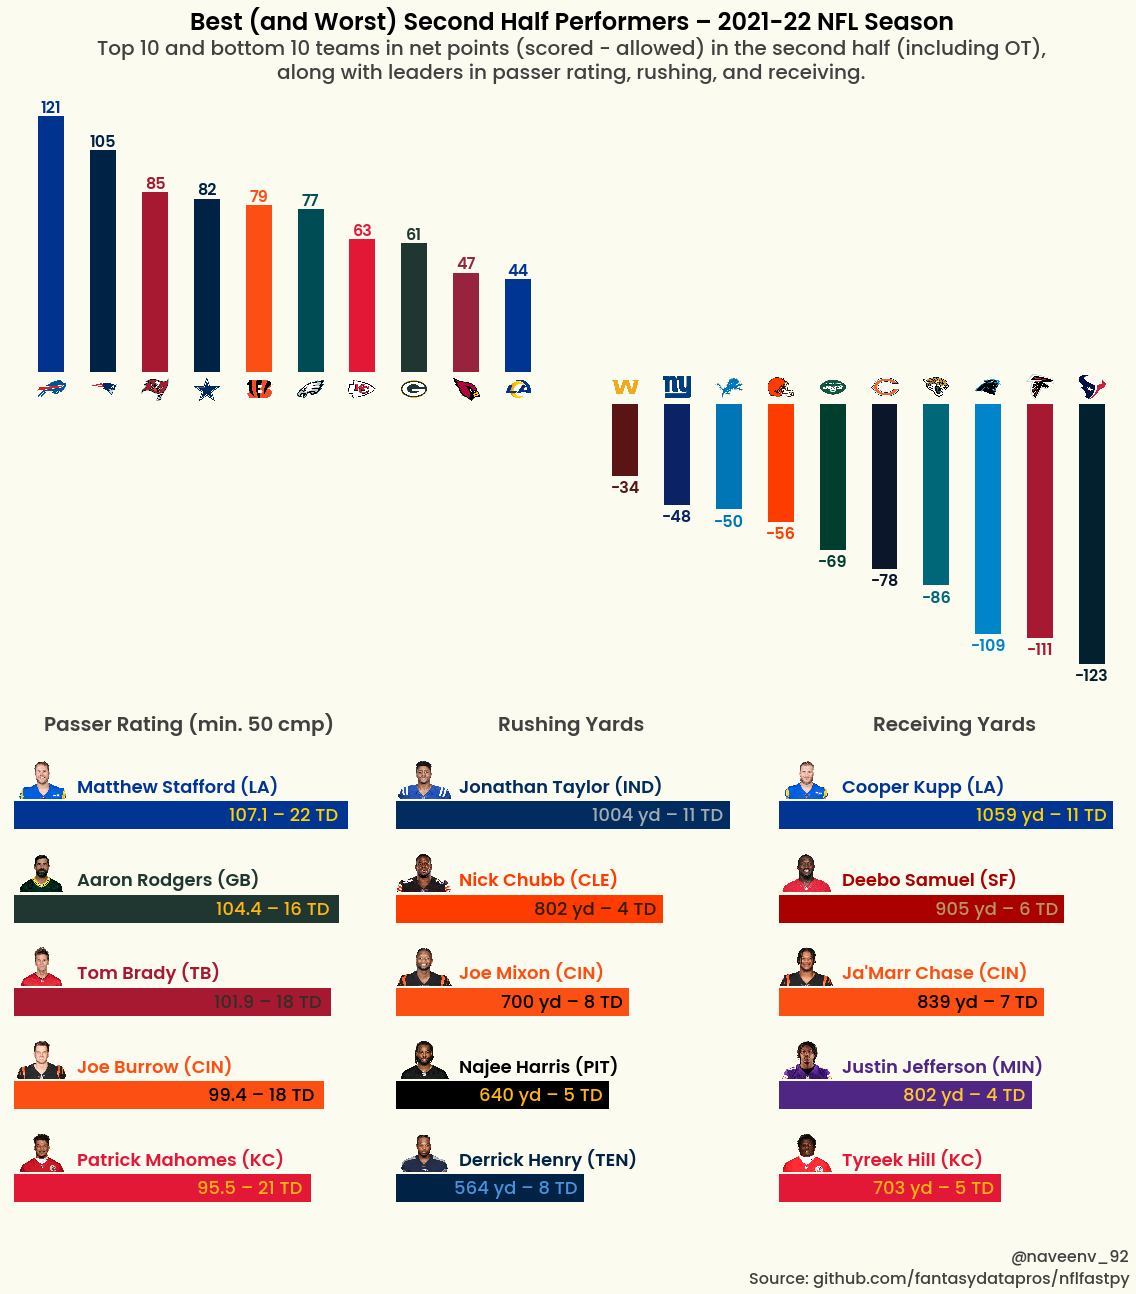

In [22]:
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.size"] = 16

NUMBER_OF_TEAMS = 32

fig = plt.figure(figsize=(20, 22), facecolor="#fbfbf0")
gs = fig.add_gridspec(nrows=3, ncols=6, hspace=0.04, height_ratios=[0.05, 1, 0.7])

ax_title = fig.add_subplot(gs[0, :], frame_on=False)
ax_pts_top = fig.add_subplot(gs[1, :3], frame_on=False)
ax_pts_bottom = fig.add_subplot(gs[1, 3:], frame_on=False)
ax_pass = fig.add_subplot(gs[2, :2], frame_on=False)
ax_rush = fig.add_subplot(gs[2, 2:4], frame_on=False)
ax_rec = fig.add_subplot(gs[2, 4:], frame_on=False)

# Point Differential
ax_pts_top.bar(range(10), df_2h_pts.head(10)["pts_diff"], width=0.5, color=df_2h_pts.head(10)["team_color"])
ax_pts_bottom.bar(range(10), df_2h_pts.tail(10)["pts_diff"], width=0.5, color=df_2h_pts.tail(10)["team_color"])

# Add bar annotations
for i, val in enumerate(df_2h_pts.head(10)["pts_diff"]):
    ax_pts_top.text(i, val + 2, val, ha="center", va="baseline", fontweight=600, color=df_2h_pts.iloc[i].team_color)
    
    # Logos
    team = df_2h_pts.iloc[i].team
    im = np.array(Image.open(f"./logo-{team}.png"))
    xy = [i, -8]
    imbox = OffsetImage(im, zoom=0.06)
    imbox.image.axes = ax_pts_top
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_pts_top.add_artist(ab)
    
for i, val in enumerate(df_2h_pts.tail(10)["pts_diff"]):
    low_index = i + (NUMBER_OF_TEAMS - 10)
    ax_pts_bottom.text(i, val - 2, val, ha="center", va="top", fontweight=600, color=df_2h_pts.iloc[low_index].team_color)
    
    # Logos
    team = df_2h_pts.iloc[low_index].team
    im = np.array(Image.open(f"./logo-{team}.png"))
    xy = [i, 8]
    imbox = OffsetImage(im, zoom=0.06)
    imbox.image.axes = ax_pts_bottom
    
    ab = AnnotationBbox(
        imbox, xy,
        frameon=False
    )
    
    ax_pts_bottom.add_artist(ab)
    
# Top Passers
ax_pass.barh(range(5), df_2h_pass.head(5)["passer_rating"][::-1], height=0.3, align="edge", color=df_2h_pass.head(5)["team_color"][::-1])
ax_pass.set(ylim=[0, 5])

for i, val in enumerate(df_2h_pass.head(5)["passer_rating"][::-1]):
    reindex = 4 - i
    ax_pass.text(
        val - 3, i + 0.14, 
        f"{val} – {int(df_2h_pass.iloc[reindex].tds)} TD", 
        ha="right", 
        va="center", 
        color=df_2h_pass.iloc[reindex].team_color2,
        fontsize=18, 
        fontweight=500
    )
    
    # Headshots
    player_id = df_2h_pass.iloc[reindex].gsis_id
    im = np.array(Image.open(f"./headshot-{player_id}.png").convert("RGBA"))
    xy = [0, i / 5 + 0.065]
    imbox = OffsetImage(im, zoom=0.04)
    imbox.image.axes = ax_pass
    
    ab = AnnotationBbox(
        imbox, xy,
        xycoords=ax_pass.transAxes,
        box_alignment=(0, 0),
        frameon=False
    )
    
    ax_pass.add_artist(ab)
    
    # Player Names
    ax_pass.text(
        0.18, i / 5 + 0.08,
        f"{df_2h_pass.iloc[reindex].full_name} ({df_2h_pass.iloc[reindex].team})",
        ha="left",
        va="baseline",
        transform=ax_pass.transAxes,
        color=df_2h_pass.iloc[reindex].team_color,
        fontsize=18,
        fontweight=600
    )
    
ax_pass.set_title("Passer Rating (min. 50 cmp)", loc="center", fontsize=20, fontweight=600, color="#414141")

    
# Top Rushers
ax_rush.barh(range(5), df_2h_rush.head(5)["yds"][::-1], height=0.3, align="edge", color=df_2h_rush.head(5)["team_color"][::-1])
ax_rush.set(ylim=[0, 5])

for i, val in enumerate(df_2h_rush.head(5)["yds"][::-1]):
    reindex = 4 - i
    ax_rush.text(
        val - 20, i + 0.14, 
        f"{int(val)} yd – {int(df_2h_rush.iloc[reindex].tds)} TD", 
        ha="right", 
        va="center", 
        color=df_2h_rush.iloc[reindex].team_color2,
        fontsize=18, 
        fontweight=500
    )
    
    # Headshots
    player_id = df_2h_rush.iloc[reindex].gsis_id
    im = np.array(Image.open(f"./headshot-{player_id}.png").convert("RGBA"))
    xy = [0, i / 5 + 0.065]
    imbox = OffsetImage(im, zoom=0.04)
    imbox.image.axes = ax_rush
    
    ab = AnnotationBbox(
        imbox, xy,
        xycoords=ax_rush.transAxes,
        box_alignment=(0, 0),
        frameon=False
    )
    
    ax_rush.add_artist(ab)
    
    # Player Names
    ax_rush.text(
        0.18, i / 5 + 0.08,
        f"{df_2h_rush.iloc[reindex].full_name} ({df_2h_rush.iloc[reindex].team})",
        ha="left",
        va="baseline",
        transform=ax_rush.transAxes,
        color=df_2h_rush.iloc[reindex].team_color,
        fontsize=18,
        fontweight=600
    )
    
ax_rush.set_title("Rushing Yards", loc="center", color="#414141", fontsize=20, fontweight=600)

# Top Receivers
ax_rec.barh(range(5), df_2h_rec.head(5)["yds"][::-1], height=0.3, align="edge", color=df_2h_rec.head(5)["team_color"][::-1])
ax_rec.set(ylim=[0, 5])

for i, val in enumerate(df_2h_rec.head(5)["yds"][::-1]):
    reindex = 4 - i
    ax_rec.text(
        val - 20, i + 0.14, 
        f"{int(val)} yd – {int(df_2h_rec.iloc[reindex].tds)} TD", 
        ha="right", 
        va="center", 
        color=df_2h_rec.iloc[reindex].team_color2,
        fontsize=18, 
        fontweight=500
    )
    
    # Headshots
    player_id = df_2h_rec.iloc[reindex].gsis_id
    im = np.array(Image.open(f"./headshot-{player_id}.png").convert("RGBA"))
    xy = [0, i / 5 + 0.065]
    imbox = OffsetImage(im, zoom=0.04)
    imbox.image.axes = ax_rec
    
    ab = AnnotationBbox(
        imbox, xy,
        xycoords=ax_rec.transAxes,
        box_alignment=(0, 0),
        frameon=False
    )
    
    ax_rec.add_artist(ab)
    
    # Player Names
    ax_rec.text(
        0.18, i / 5 + 0.08,
        f"{df_2h_rec.iloc[reindex].full_name} ({df_2h_rec.iloc[reindex].team})",
        ha="left",
        va="baseline",
        transform=ax_rec.transAxes,
        color=df_2h_rec.iloc[reindex].team_color,
        fontsize=18,
        fontweight=600
    )
    
ax_rec.set_title("Receiving Yards", loc="center", color="#414141", fontsize=20, fontweight=600)

# Overall Title
ax_title.text(
    0.5, 0.95,
    "Best (and Worst) Second Half Performers – 2021-22 NFL Season",
    ha="center",
    va="top",
    transform=ax_title.transAxes,
    fontweight=600,
    fontsize=24
)
ax_title.text(
    0.5, 0.1,
    "Top 10 and bottom 10 teams in net points (scored - allowed) in the second half (including OT),\nalong with leaders in passer rating, rushing, and receiving.",
    ha="center",
    va="top",
    transform=ax_title.transAxes,
    fontweight=500,
    fontsize=20,
    color="#414141"
)

# Source
ax_rec.text(
    1, -0.1,
    "@naveenv_92\nSource: github.com/fantasydatapros/nflfastpy",
    ha="right",
    va="top",
    transform=ax_rec.transAxes,
    fontweight=500,
    fontsize=16,
    color="#414141"
)

ax_title.set(xticks=[], yticks=[])
ax_pts_top.set(xticks=[], yticks=[], ylim=[-165, 150])
ax_pts_bottom.set(xticks=[], yticks=[], ylim=[-150, 165])
ax_pass.set(xticks=[], yticks=[])
ax_rush.set(xticks=[], yticks=[])
ax_rec.set(xticks=[], yticks=[])

plt.savefig("second_half_stats.png", dpi=300, bbox_inches="tight")
plt.show()